In [2]:
import pandas as pd

data = pd.read_csv('data/london_weather.csv')

#Chagement de la date : int > date avec le format YYYYMMDD
data['date'] = pd.to_datetime(data['date'].astype(str), format='%Y%m%d')

print (data['date'])

#Drop des colonnes non utiles pour la prevision de temperature
data = data.drop(columns=['sunshine']).drop(columns=['cloud_cover']).drop(columns=['global_radiation']).drop(columns=['max_temp'])
data = data.drop(columns=['min_temp']).drop(columns=['precipitation']).drop(columns=['pressure']).drop(columns=['snow_depth'])

data.set_index('date', inplace=True)

0       1979-01-01
1       1979-01-02
2       1979-01-03
3       1979-01-04
4       1979-01-05
           ...    
15336   2020-12-27
15337   2020-12-28
15338   2020-12-29
15339   2020-12-30
15340   2020-12-31
Name: date, Length: 15341, dtype: datetime64[ns]


In [3]:
data_weekly = data.resample('W').mean()

print(data_weekly['mean_temp'])
print(data_weekly.index)

#data_weekly.to_csv('data_weekly.csv')

date
1979-01-07   -1.700000
1979-01-14    1.957143
1979-01-21    2.228571
1979-01-28   -0.428571
1979-02-04    2.171429
                ...   
2020-12-06    5.257143
2020-12-13    5.257143
2020-12-20    9.614286
2020-12-27    7.757143
2021-01-03    1.400000
Freq: W-SUN, Name: mean_temp, Length: 2192, dtype: float64
DatetimeIndex(['1979-01-07', '1979-01-14', '1979-01-21', '1979-01-28',
               '1979-02-04', '1979-02-11', '1979-02-18', '1979-02-25',
               '1979-03-04', '1979-03-11',
               ...
               '2020-11-01', '2020-11-08', '2020-11-15', '2020-11-22',
               '2020-11-29', '2020-12-06', '2020-12-13', '2020-12-20',
               '2020-12-27', '2021-01-03'],
              dtype='datetime64[ns]', name='date', length=2192, freq='W-SUN')


In [4]:
missing_p = data_weekly.isnull().mean()*100
missing_p = missing_p[missing_p > 0]
print (missing_p)

data = pd.read_csv('data/data_weekly.csv')

Series([], dtype: float64)


In [5]:
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)
print (data)

            mean_temp
date                 
1979-01-07  -1.700000
1979-01-14   1.957143
1979-01-21   2.228571
1979-01-28  -0.428571
1979-02-04   2.171429
...               ...
2020-12-06   5.257143
2020-12-13   5.257143
2020-12-20   9.614286
2020-12-27   7.757143
2021-01-03   1.400000

[2192 rows x 1 columns]


In [6]:
# Les donnes ont des valeurs négatives et nulles, transformation pour pouvoir utiliser un modele multiplicatif 
# Penser a retirer 10 à la fin pour la prediction
data['mean_temp'] = data['mean_temp'] +10

<Axes: xlabel='date'>

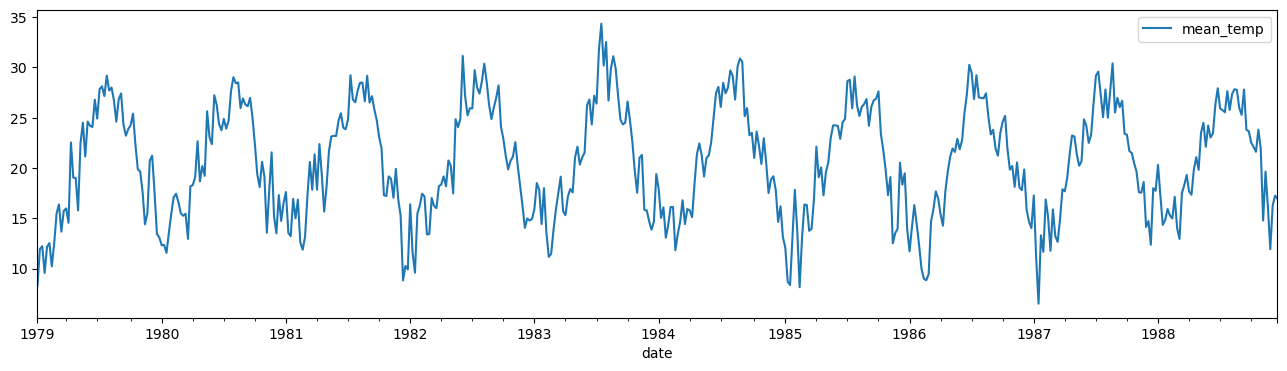

In [7]:
#Test pour determiner la period de la data
test = data[0:520]
test.plot(y="mean_temp", figsize= (16,4))

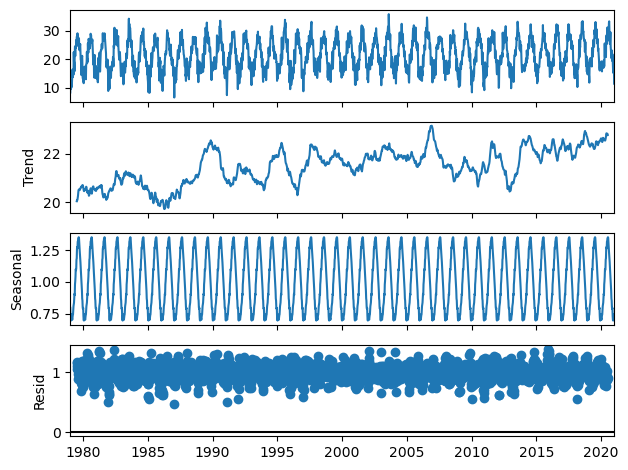

In [8]:
#Decomposotion de la suite pour voir les tendances, residus
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

decompositionM = seasonal_decompose(data, model='multiplicative',period=52)
decompositionM.plot()
plt.show()

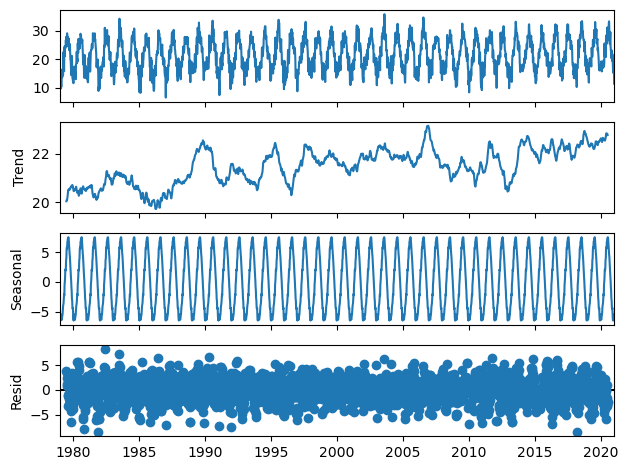

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

decompositionA = seasonal_decompose(data, model='additive',period=52)
decompositionA.plot()
plt.show()

In [10]:
#Test de la saisonalite, si p_value < 0,05, la serie est stationnaire
from statsmodels.tsa.stattools import adfuller
result_data = adfuller(data.mean_temp)[1]
print('p-value de la serie:', result_data)

p-value de la serie: 2.3393140963715053e-29


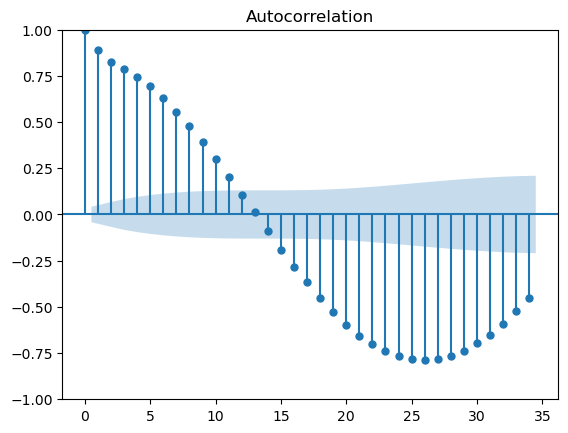

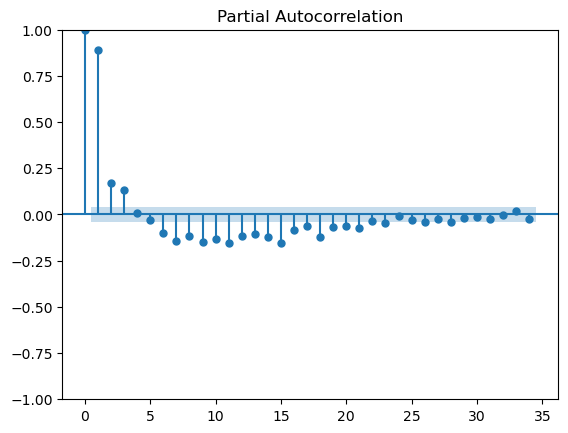

In [11]:
#Visualisation de la autocorrelation
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(data)
plot_pacf(data)
plt.show()

In [34]:
#Determiner les melleurs parametre (q p d)(Q P D) de sarima
from pmdarima import auto_arima

model_auto = auto_arima(data['mean_temp'], seasonal=True, m=52, stepwise=False, trace=True)

In [28]:
#Train le modele en focntion des meilleurs parametres
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

train = data[1:520]
test = data [520:624]

#model = ARIMA(train, order=(1,1,2))
#model_fit = model.fit()

model = SARIMAX(train, order=(3, 1, 2), seasonal_order=(1, 1, 1, 52))
model_fit = model.fit(maxiter=100)

c:\Users\Elliot\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\Elliot\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


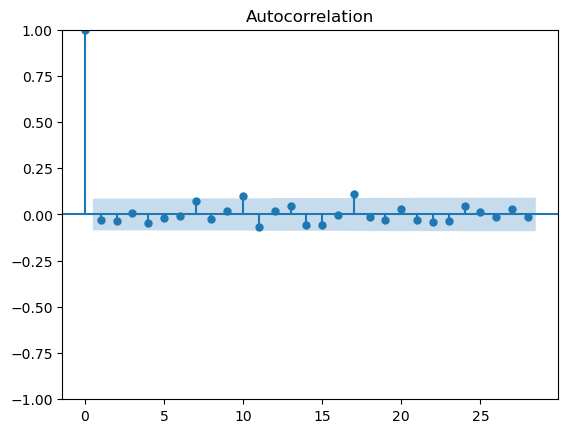

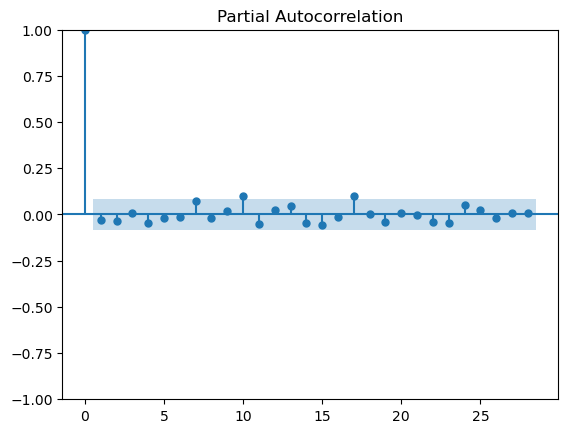

In [29]:
#Visualisation des residus pour determiner si le modele est robuste
residuals = model_fit.resid
plot_acf(residuals)
plot_pacf(residuals)
plt.show()

In [30]:
# Vérification de la stationnarité des résidus avec ADF
result_resid = adfuller(residuals)[1]
print('p-value residus:', result_resid)

p-value residus: 0.0


In [31]:
import numpy as np
def plot_forecast(fc, train, test, upper=None, lower=None):
    is_confidence_int = isinstance(upper, np.ndarray) and isinstance(lower, np.ndarray)
    
    fc_series = pd.Series(fc, index=test.index)
    lower_series = pd.Series(upper, index=test.index) if is_confidence_int else None
    upper_series = pd.Series(lower, index=test.index) if is_confidence_int else None

    # Plot
    plt.figure(figsize=(10,4), dpi=10)
    plt.plot(train, label='training', color='b')
    plt.plot(test, label='actual', color='b', ls='--')
    plt.plot(fc_series, label='forecast', color='orange')
    if is_confidence_int:
        plt.fill_between(lower_series.index, lower_series, upper_series, color='k')
    plt.title('Forecast vs Actuals')
    plt.legend(loc='upper left', fontsize=8)

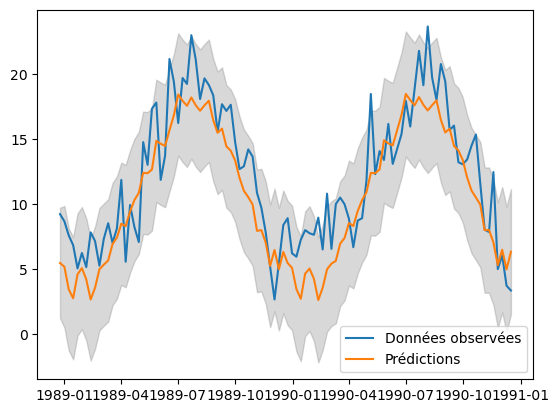

In [32]:
forecast = model_fit.get_forecast(steps = 104)
forecast_mean = forecast.predicted_mean -10
forecast_conf_int = forecast.conf_int() -10

# Affichage des prévisions avec intervalle de confiance
plt.plot(data[520:624] -10, label="Données observées")
plt.plot(forecast_mean, label="Prédictions")
plt.fill_between(forecast_conf_int.index, forecast_conf_int.iloc[:, 0], forecast_conf_int.iloc[:, 1], color='grey', alpha=0.3)
plt.legend()
plt.show()